In [1]:
# primitive
import sys
import os
import pickle
import itertools
from joblib import Parallel, delayed
from pprint import pprint
import itertools
from collections import Counter
from time import time

# data handling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# text
import MeCab
import spacy
import gensim
from gensim.models import KeyedVectors

# nn
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchtext.vocab import Vocab

# handmade
src = '../../src'
if src not in sys.path: sys.path.append(src)

from const import *

In [3]:
paths = [
    DIR_DATA,
    DIR_MODEL,
    DIR_LOG,
    DEVICE,
    TOKENIZER,
    DIR_MECAB_DIC,
    DEVICE
]
pprint(paths)

['../../data',
 '../../model',
 '../../log',
 'cuda',
 'mecab',
 '/usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd',
 'cuda']


Functions

In [5]:
f = os.path.join(DIR_DATA, 'livedoor&text=text.csv')
dataset = pd.read_csv(f)

# 概観
print(dataset.shape)
display(dataset.head())
display(pd.DataFrame(dataset.media.value_counts()).sort_index().T.style.background_gradient('Blues', axis=1))

(7366, 2)


,media,text
0,3,前回の「プロに聞く“合コンの極意”（前編） 合コンアナリスト水谷麻衣に聞く、合コンの勝ちパタ...
1,3,「3年で転職は早すぎる？」「将来が見えない」「仕事が面白くない」・・・若手社会人の悩みは尽き...
2,3,こんにちは、「ビズリーチ年収1000万円研究所」所長の佐藤和男です。この研究所では、年収10...
3,3,6月7日、表参道のカフェバー「MERCER CAFE TERRACE HOUSE」でHenn...
4,3,「3年で転職は早すぎる？」「将来が見えない」「仕事が面白くない」・・・若手社会人の悩みは尽き...


,0,1,2,3,4,5,6,7,8
media,870,870,863,511,870,842,770,900,870


Dataset

In [6]:
# torch Dataset
from torch.utils.data.dataset import Dataset
class LivedoorDataset(Dataset):
    def __init__(self, dataframe):
        '''
        input:
            dataframe: pandas.DataFrame of (label, text) shape.
        output:
            None
        '''
        self.label = dataframe.iloc[:, 0]
        self.text = dataframe.iloc[:, -1]
        
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, idx):
        return (self.label[idx], self.text[idx])

dataset = LivedoorDataset(dataset)
print('dataset length', len(dataset))
print('dataset sample', dataset[1000])

dataset length 7366
dataset sample (4, '昨年7月から9月に掛けてドラマがオンエアされ、3月17日より公開となる映画『桜蘭高校ホスト部』。ドラマ版でおなじみの川口春奈と山本裕典はもちろん、AKB48の篠田麻里子や韓国の“野獣系アイドル”2PMのニックンなど、多彩で豪華な出演者も話題の同作。ドラマ版の主題歌「FRiDAY-MA-MAGiC」に続き、現役女子大生シンガーソングライターのmiwaの手掛ける映画主題歌「いくつになっても」が遂に完成した。初めてスカの要素を取り入れ、パンキッシュで楽しいROCKとなった主題歌「いくつになっても」に関して、miwaは「曲を作る時に撮影直後の映画の映像を見せてもらったのですが、まだ編集中にも関わらず画面から溢れるくらい楽しさが伝わってきて、自分もがんばんなきゃ！と思いながら作りました。もともと原作の大ファンだったので、世界観には自信があります（笑）。映画と同じくこの曲も聞いた人が明るく、元気になってもらえたら嬉しいです。」とコメントを寄せた。miwaは、昨年末に行われたZepp Tokyoでのワンマンライブもチケットが即日完売。2月1日に発売したシングル「片想い」もオリコン・デイリーランキング初登場7位を記録しており、明日4日放送のTBS「CDTV」ほか音楽番組の出演も続々と決まっている。テレビ版の主題歌「FRiDAY-MA-MAGiC」では、明るく激しいガールズロックサウンドが十代の女性を中心に好評価を獲得。映画同様に、スケールアップした彼女が贈る主題歌「いくつになっても」は、映画と共に日本に元気を与えてくれるだろう。2月4日からは、「いくつになっても」を使用した映画の新予告編が全国の劇場にて上映開始。miwaが担当するラジオ番組「miwaのオールナイトニッポン」（ニッポン放送、全国ネット）でも7日深夜25時からの生放送内でいち早くオンエアされる予定。CDの発売は未定だが、22日より着うた(R)での配信が決定している。■関連記事・チケット即完、現役女子大生miwaが『桜蘭高校ホスト部』主題歌を担当')


In [7]:
# split dataset
from torch.utils.data.dataset import random_split
TEST_RATE = 0.20
n = len(dataset)
n_test = int(np.floor(n * TEST_RATE))
n_train = int(n - n_test)
train_dataset, test_dataset = \
        random_split(dataset, [n_train, n_test], generator=torch.Generator().manual_seed(12345))

In [8]:
def show_dataset_label_balance(dataset):
    c = Counter([l for l, _ in dataset])
    df = pd.DataFrame(c.most_common()).set_index(0).sort_index().T
    display(df.style.background_gradient('Blues', axis=1))

show_dataset_label_balance(train_dataset)
show_dataset_label_balance(test_dataset)

0,0,1,2,3,4,5,6,7,8
1,698,687,690,392,675,688,632,732,699


0,0,1,2,3,4,5,6,7,8
1,172,183,173,119,195,154,138,168,171


Vocabulary

In [9]:
# Construct vocabulary; using only train and valid dataset
SAMPLE_SENT = 'ワンマンライブに行きたい'
# tokenizers
nlp = spacy.load('ja_ginza')
sudachi_tokenizer = lambda text: [str(token) for token in nlp(text)] # text to list of tokens
print('sudachi:', sudachi_tokenizer(SAMPLE_SENT))

tagger = MeCab.Tagger(f'-Owakati -d {DIR_MECAB_DIC}')
mecab_tokenizer = lambda text: tagger.parse(text).split(' ')[:-1]
print('mecab  :', mecab_tokenizer(SAMPLE_SENT))

tokenizer = sudachi_tokenizer if TOKENIZER=='sudachi' else mecab_tokenizer
print('output :', tokenizer(SAMPLE_SENT))

sudachi: ['ワンマン', 'ライブ', 'に', '行き', 'たい']
mecab  : ['ワンマンライブ', 'に', '行き', 'たい']
output : ['ワンマンライブ', 'に', '行き', 'たい']


In [10]:
%%time
counter = Counter()
# logging
start = time()

for e, (label, text) in enumerate(train_dataset):
    counter.update(tokenizer(text))
    
    # logging
    if e!=0 and e%(1000)==0:
        current = time()
        interval = current-start
        print(f'| {(e):4d} samples done | {interval:5.2f} s |')
        start = current
        
vocab = Vocab(counter, min_freq=1)
PAD = vocab.stoi['<pad>']

# serialize
file_out = os.path.join(DIR_DATA, f'vocab_{TOKENIZER}.pkl') # 本当は dic で分けるべき
if not os.path.isfile(file_out):
    with open(file_out, 'wb') as f:
        pickle.dump(vocab, f)
    print(f'{file_out} : created')
else:
    print(f'{file_out} : file exists')

# test
print([vocab[str(token)] for token in nlp('私は人間です。')])

# if TOKENIZER == 'sudachi':
# | 1000 samples done | 284.68 s |
# | 2000 samples done | 279.84 s |
# | 3000 samples done | 283.89 s |
# | 4000 samples done | 278.97 s |
# | 5000 samples done | 280.47 s |
# [147, 9, 546, 29, 5]
# CPU times: user 27min 27s, sys: 9.12 s, total: 27min 36s
# Wall time: 27min 37s

| 1000 samples done |  1.03 s |
| 2000 samples done |  1.04 s |
| 3000 samples done |  1.04 s |
| 4000 samples done |  1.05 s |
| 5000 samples done |  0.99 s |
../../data/vocab_mecab.pkl : file exists
[131, 8, 603, 26, 4]
CPU times: user 6.27 s, sys: 36.6 ms, total: 6.3 s
Wall time: 6.3 s


In [11]:
# tokenizer, label
text_pipeline = lambda text: [vocab.stoi[str(token)] for token in tokenizer(text)]
label_pipeline = lambda x: int(x)

In [12]:
with open(os.path.join(DIR_DATA, 'vocab_sudachi.pkl'), 'rb') as f:
    vocab_sudachi = pickle.load(f)
with open(os.path.join(DIR_DATA, 'vocab_mecab.pkl'), 'rb') as f:
    vocab_mecab = pickle.load(f)


print('sudachi size:', len(vocab_sudachi))
print('mecab size  :', len(vocab_mecab))

sudachi size: 76029
mecab size  : 85880


input text overview
- todo: eda に切り出す

In [13]:
# dataloader
train_dataloader = DataLoader(train_dataset,
                              batch_size=64,
                              shuffle=False,)

test_dataloader = DataLoader(test_dataset,
                              batch_size=64,
                              shuffle=False,)

all_texts = []
for batch, (labels, texts) in enumerate(train_dataloader):

    all_texts += [text_pipeline(text) for text in texts]
#     break

In [14]:
c = Counter(itertools.chain.from_iterable(all_texts))
freq = [(vocab.itos[t], n) for t, n in c.most_common()]

In [15]:
freq[200:250]

[('とか', 1460),
 ('監督', 1457),
 ('られる', 1449),
 ('くれ', 1434),
 ('撮影', 1414),
 ('×', 1413),
 ('好き', 1409),
 ('Twitter', 1403),
 ('声', 1402),
 ('じゃ', 1387),
 ('一', 1371),
 ('てる', 1363),
 ('見る', 1354),
 ('による', 1340),
 ('ソフトウェア', 1337),
 ('製品', 1337),
 ('行っ', 1322),
 ('ユーザー', 1320),
 ('女子', 1317),
 ('しれ', 1315),
 ('世界', 1299),
 ('数', 1298),
 ('現在', 1294),
 ('１', 1292),
 ('相手', 1270),
 ('使っ', 1269),
 ('目', 1267),
 ('くれる', 1256),
 ('話', 1239),
 ('考え', 1235),
 ('＆', 1226),
 ('用', 1217),
 ('しかし', 1210),
 ('同じ', 1209),
 ('ほど', 1183),
 ('カメラ', 1183),
 ('他', 1176),
 ('くる', 1172),
 ('方法', 1154),
 ('男', 1154),
 ('開始', 1152),
 (':', 1151),
 ('注目', 1142),
 ('でし', 1131),
 ('使用', 1128),
 ('関連リンク', 1113),
 ('購入', 1110),
 ('シリーズ', 1106),
 ('持っ', 1103),
 ('よく', 1098)]

ここまで独立させて EDA したいな

# Experiments

Class, Functions

In [16]:
class LSTMClassifier(nn.Module):
    
    def __init__(self, vocab_size, embed_dim, h_dim, class_dim):
        super(LSTMClassifier, self).__init__()
        # ToDo: 学習済み Embedding の導入
        # vocab 内の語について，index 順に学習済み Embedding を取得し，格納する
        # https://kento1109.hatenablog.com/entry/2018/03/15/153652
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD)
        self.embedding.weight.requires_grad = False # ?
        # ToDo: 高速化（現状不便ないので優先度低）
        # sequence_fisrt の方が効率的らしい
        # - https://www.reddit.com/r/pytorch/comments/fpxjm4/why_batch_first_in_lstm/
        self.lstm = nn.LSTM(embed_dim, h_dim, batch_first=True)
        self.linear = nn.Linear(h_dim, class_dim)
        
    def forward(self, texts):
        emb = self.embedding(texts)
#         return emb
        o, (h_n, c_n) = self.lstm(emb)
        logit = self.linear(h_n) # logit ではない
        return logit

In [17]:
# train
def iter_train(dataloader, model, loss_fn, optimizer):
    current_size = 0
    current_loss, current_correct = 0, 0
    
    for batch, (labels, texts) in enumerate(dataloader):
        
        # indexing
        texts = [torch.tensor(text_pipeline(text)) for text in texts]
        texts = pad_sequence(texts, batch_first=True, padding_value=PAD)
            
        # send to GPU
        labels, texts = labels.to(DEVICE), texts.to(DEVICE)

        # pred
        pred = model(texts)[0]

        # get loss
        loss = loss_fn(pred, labels)

        # get gradient
        optimizer.zero_grad() # バッチごとに勾配をリセット
        loss.backward()

        # back propagate
        # 手動；todo: optimizer.step() の動作確認，デバッグ
        for layer_num, param in enumerate(model.parameters()):
            if layer_num==0:
                continue
            LR = optimizer.state_dict()['param_groups'][0]['lr']
            param.data -= LR * param.grad.data
#         optimizer.step()
        
        current_size += len(labels)
        current_loss += loss.item()
        current_correct += (pred.argmax(axis=1).squeeze()==labels).type(torch.int).sum().item()
        
        mean_loss = current_loss/current_size
        mean_correct = current_correct/current_size

        # logging
        if batch%30==0 and batch!=0:
            split = 'train'
            print(f'| {split*(1 if batch==0 else 0):5} | batch {batch:3d} '
                  f'| correct total: {mean_correct:0.8f} | loss total: {mean_loss:0.8f} |')
    
    return mean_correct, mean_loss

if DEVICE=='cuda':
    # 1 epoch sample execution
    sample_dataloader = DataLoader(train_dataset,
                                   batch_size=64,
                                   shuffle=False,)
    LR = 1e-4
    model = LSTMClassifier(len(vocab), 300, 100, 9).to(DEVICE)
    loss_fn = nn.CrossEntropyLoss().to(DEVICE)
    optimizer = torch.optim.SGD(model.parameters(), lr=LR)
    iter_train(sample_dataloader, model, loss_fn, optimizer)

|       | batch  30 | correct total: 0.11391129 | loss total: 0.03433470 |
|       | batch  60 | correct total: 0.11296107 | loss total: 0.03433871 |
|       | batch  90 | correct total: 0.11761676 | loss total: 0.03432163 |


In [18]:
# validate
def iter_test(dataloader, model, loss_fn):
    test_size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        # 全ての勾配計算を無効化
        for batch, (labels, texts) in enumerate(dataloader):
            
            # indexing
            texts = [torch.tensor(text_pipeline(text)) for text in texts]
            texts = pad_sequence(texts, batch_first=True, padding_value=PAD)
            
            # send to GPU
            labels, texts = labels.to(DEVICE), texts.to(DEVICE)
            
            # predict
            pred = model(texts)[0]

            # get loss
            test_loss += loss_fn(pred, labels).item()

            # eval
            pred_labels = pred.argmax(axis=1).squeeze() # この squeeze は問題ないのか？
            correct += (pred_labels==labels).type(torch.int).sum().item()

    correct /= test_size # Epoch 終了時点の Accuracy（正答数 / テストサンプルサイズ）
    test_loss /= test_size # Epoch 終了時点の 1 サンプルあたり Loss 平均（Loss / テストサンプルサイズ）

    split = 'test'
    print(f'| {split:5} | accuracy: {correct:0.4f} | loss avg: {test_loss:6.8f} |', end='')
    
    return correct, test_loss

if DEVICE=='cuda':
    # sample execution
    sample_dataloader = DataLoader(test_dataset,
                                   batch_size=64,
                                   shuffle=False,)
    LR = 1e-2
    model = LSTMClassifier(len(vocab), 300, 100, 9).to(DEVICE)
    loss_fn = nn.CrossEntropyLoss().to(DEVICE)
    optimizer = torch.optim.SGD(model.parameters(), lr=LR)
    iter_test(sample_dataloader, model, loss_fn)

| test  | accuracy: 0.1154 | loss avg: 0.03583086 |

Execute

In [19]:
batchsizes = [128]
lrs = [1e-5]
mos = [0.9]
n_epochss = [1]

for (batchsize, lr, mo, n_epochs) in itertools.product(batchsizes, lrs, mos, n_epochss):
    # dataloader
    train_dataloader = DataLoader(train_dataset,
                                  batch_size=batchsize,
                                  shuffle=False,)

    test_dataloader = DataLoader(test_dataset,
                                  batch_size=batchsize,
                                  shuffle=False,)

    # modules
    loss_fn = nn.CrossEntropyLoss().to(DEVICE)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=mo)
    # sample = []

    # define network architecture
    model = LSTMClassifier(len(vocab), 300, 100, 9).to(DEVICE)

    # train model
    result = []
    start = time()
    for epoch in range(n_epochs):

        print(f'{"-"*28} Epoch {epoch} {"-"*28}')
        train_acc, train_loss = iter_train(train_dataloader, model, loss_fn, optimizer)
        test_acc, test_loss = iter_test(test_dataloader, model, loss_fn)
        print(f' {time()-start:5.2f} sec |')
        result.append((epoch, train_acc, train_loss, test_acc, test_loss))

    print('done!')
    
    # **
    # save
    # *
    filename_base = f'lstm&batchsize={batchsize:03d}&lr={lr:.5f}&mo={mo:.1f}&epochs={n_epochs:d}'
    filename_model = os.path.join(DIR_MODEL, filename_base+'.pth')
    filename_log = os.path.join(DIR_LOG, filename_base+'.csv')

    # save model
    if not os.path.isfile(filename_model):
        torch.save(model, filename_model)
        print(f'{filename_model} : created')
    else:
        print(f'{filename_model} : exists')

    # save log
    if not os.path.isfile(filename_log):
        result = pd.DataFrame(result).rename(columns={0: 'epoch',
                                                      1: 'train_acc',
                                                      2: 'train_loss',
                                                      3: 'test_acc',
                                                      4: 'test_loss'})
        result.to_csv(filename_log, index=False)
        print(f'{filename_log} : created')
    else:
        print(f'{filename_log} : exists')

---------------------------- Epoch 0 ----------------------------
|       | batch  30 | correct total: 0.10836694 | loss total: 0.01719580 |
| test  | accuracy: 0.0944 | loss avg: 0.01795454 | 31.27 sec |
done!
../../model/lstm&batchsize=128&lr=0.00001&mo=0.9&epochs=1.pth : created
../../log/lstm&batchsize=128&lr=0.00001&mo=0.9&epochs=1.csv : created


- バッチサイズめっちゃ下げてみた．（32->8）
- 一回，手作業で Loss 算出してみるべき

- バッチサイズ下げて学習率上げたら，上下が出てきた．探索してる間は出てきた

- パラメータわからんなら optuna も手
- 今一度，CrossEntropyLoss の仕様見てみる？

In [21]:
# # load trained model
# model = torch.load(filename_model)
# model

LSTMClassifier(
  (embedding): Embedding(91630, 300, padding_idx=1)
  (lstm): LSTM(300, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=9, bias=True)
)

- 学習できてない？
  - embedding がいまいち？
  - 局所解？
  - LR？
  - なんかミスってる？

# Evaluation

In [20]:
%%time
def predict_dataloader(dataloader, model):
    test_size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    all_labels = []
    
    with torch.no_grad():
        # 全ての勾配計算を無効化
        for batch, (labels, texts) in enumerate(dataloader):
            
            all_labels.append(list(labels.numpy()))
            
            # indexing
            texts = [torch.tensor(text_pipeline(text)) for text in texts]
            texts = pad_sequence(texts, batch_first=True, padding_value=PAD)
            
            # send to GPU
            labels, texts = labels.to(DEVICE), texts.to(DEVICE)
            
            # predict
            pred = model(texts)[0]
            pred = pred.cpu().numpy()
            if batch==0:
                pred_all = pred
            else:
                pred_all = np.append(pred_all, pred, axis=0)
    
    return np.array(list(itertools.chain.from_iterable(all_labels))), pred_all.argmax(axis=1)

all_labels, pred = predict_dataloader(test_dataloader, model)
pred

CPU times: user 3.19 s, sys: 483 ms, total: 3.67 s
Wall time: 3.64 s


array([6, 6, 6, ..., 6, 6, 6])

<AxesSubplot:xlabel='col_0', ylabel='row_0'>

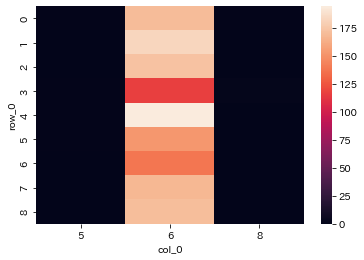

In [21]:
sns.heatmap(pd.crosstab(all_labels, pred))

# Primitive model

Check embedding

In [22]:
def get_feat_and_label(dataloader):
    X, y = [], []
    for batch, (labels, texts) in enumerate(dataloader):
        texts = [torch.tensor(text_pipeline(text)) for text in texts]
        texts = pad_sequence(texts, batch_first=True, padding_value=PAD)
        labels, texts = labels.to(DEVICE), texts.to(DEVICE)
        emb = model.embedding(texts).detach().cpu().numpy()
        emb = emb.mean(axis=1)
        X.append(emb)
        y.append(labels.detach().cpu().numpy())
    
    X = np.array(list(itertools.chain.from_iterable(X)))
    y = np.array(list(itertools.chain.from_iterable(y)))
        
    return X, y

model = LSTMClassifier(len(vocab), 300, 100, 9).to(DEVICE)
X_train, y_train = get_feat_and_label(train_dataloader)
X_test, y_test = get_feat_and_label(test_dataloader)

(9, 300)


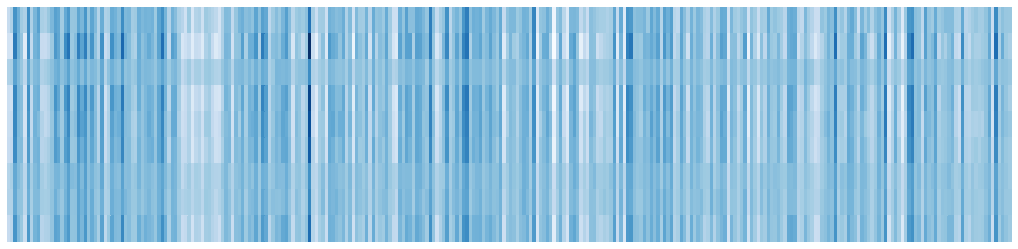

In [23]:
%matplotlib inline

def show(embedding):
    w = 18
    h = embedding.shape[0] * (w / 300) * 8

    fig = plt.figure(figsize=(w, h))
    ax = fig.add_subplot(1, 1, 1)

    print(embedding.shape)
    sns.heatmap(pd.DataFrame(embedding), cbar=False, xticklabels=False, yticklabels=False, cmap='Blues')

    plt.show()
    return

df = pd.DataFrame(X_train)
show(df.groupby(y_train).mean())

ベンチマーク；SVM で 82 %

In [24]:
from sklearn.svm import SVC

model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

sum(y_pred == y_test) / len(y_test)

0.8194161575016972

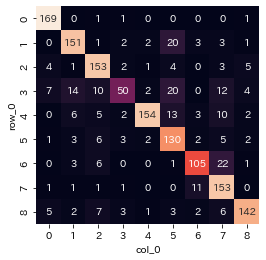

In [25]:
%matplotlib inline

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
sns.heatmap(pd.crosstab(y_test, y_pred), cbar=False, annot=True, fmt='d')
plt.show()

Work

In [17]:
%%time
# embed
wv = KeyedVectors.load_word2vec_format('/data/chive/chive-1.2-mc5/chive-1.2-mc5.txt')
wv

CPU times: user 14min 50s, sys: 14.3 s, total: 15min 4s
Wall time: 15min 4s
